In [1]:
import os
import shutil
import glob
import zipfile

import pandas as pd
import numpy as np

import re

import matplotlib.pyplot as plt
from PIL import Image
import cv2

# 1. 데이터 경로 변경 및 통합

## 1-1) 이미지 압축해제 후 경로 변경 (1번만 수행)

In [2]:
ba_path="/Users/eunha/Desktop/골밀도데이터/BoneAge/"
data_path="/Users/eunha/Desktop/골밀도데이터/BoneAgeData/"

#xlsx파일과 zip파일 경로 추출
xls_path=glob.glob(ba_path+"/*.xlsx")
zip_path=glob.glob(ba_path+"/*.zip")

In [3]:
#zip파일 압축 해제 후 위치 변경
for zip in zip_path:
    zipfile.ZipFile(zip).extractall(data_path+"images")

In [4]:
#이중 폴더 내 이미지 꺼내기
infolder_path=glob.glob(data_path+"images"+"/BA*")
for in_path in infolder_path:
    tmp=os.listdir(in_path)
    for i in tmp:
        os.rename(in_path+"/"+i,data_path+"images/"+i)
    
    os.rmdir(in_path)

## 1-2) xlsx 파일 합친 후 저장 (1번만 수행)

In [5]:
#xlsx파일 읽어서 합치기
df=pd.DataFrame()
for xlsx in xls_path:
    sub=pd.read_excel(xlsx)
    
    id= pd.DataFrame([int(re.findall(r'\d+',str(x))[0]) for x in sub["No."]])
    ba=(sub["BA 1"]+sub["BA 2"])/2
    gender=sub["성별"]-1
    
    tmp=pd.concat([id,ba,gender],axis=1,ignore_index=True)
    df=pd.concat([df,tmp],axis=0,ignore_index=True)

df.columns=["ID","BoneAge","Gender"]

In [7]:
#labeling 데이터 저장
df.to_excel(data_path+"clin_info.xlsx",index=False)

# 2. 1차 이미지 전처리

(1번 코드 실행한 경우 여기부터 수행)  
ROI 구간당 전처리하기 전 전체 이미지 전처리 수행

## 2-1) 라벨링 데이터 불러오기

In [2]:
#label 정보 불러오기
data_path="/Users/eunha/Desktop/골밀도데이터/BoneAgeData/"

df=pd.read_excel(data_path+"clin_info.xlsx")

## 2-2) 샘플 이미지로 전처리 결과 확인

In [3]:
#샘플 이미지 흑백으로 불러오기
img_path=glob.glob(data_path+"images/"+str(df.ID[0])+"_?.jpg")[0]
img=cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
img.shape #shape 확인

(1776, 1416)

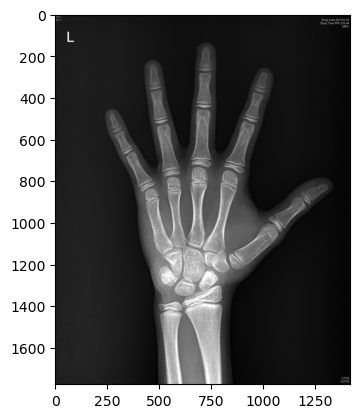

In [4]:
#원본 이미지 확인
plt.imshow(img,"gray")

### Resize

In [5]:
#이미지 가로 세로 비율 확인
img.shape[0]/img.shape[1]

1.2542372881355932

In [6]:
#이미지 사이즈 재설정 (기존 1.25비율 유지)
resized_img=cv2.resize(img,(800,1000))

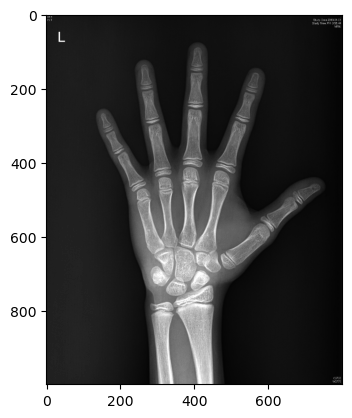

In [7]:
#resized 이미지 확인
plt.imshow(resized_img,"gray")

### Normalize

In [8]:
#이미지 min max 정규화
normal_img=cv2.normalize(resized_img, None, 0, 255, cv2.NORM_MINMAX)

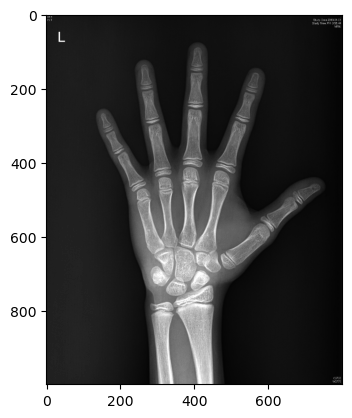

In [9]:
#normalized 이미지 확인
plt.imshow(normal_img,"gray")

### Denoise

In [10]:
#이미지 노이즈 제거
    #제거 강도: 20
    #templateWindowSize :5
    #searchWindowSize : 15
denoise_img=cv2.fastNlMeansDenoising(normal_img, None, 20, 5, 15)

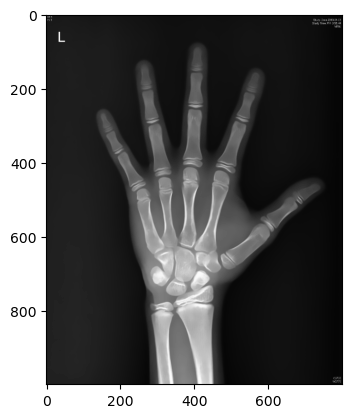

In [11]:
#denoised 이미지 확인
plt.imshow(denoise_img,"gray")

### Equalize

In [12]:
#이미지 평탄화
    #cv2.equalizeHist 사용시 전체 기준이므로 contrast가 날아가는 문제 발생
    #따라서 bin 구간 나누어 평탄화 가능한 clahe로 평탄화 수행
    #clipLimit: 2
    #tileGridSize: 5 x 5
clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(5,5))
equal_img=clahe.apply(denoise_img)

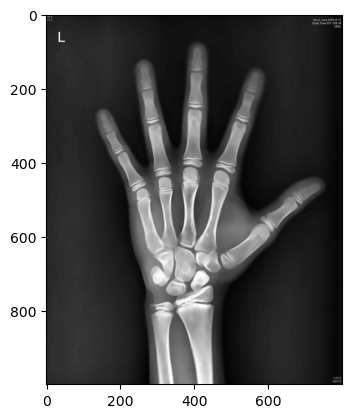

In [13]:
#equalized 이미지 확인
plt.imshow(equal_img,"gray")

### 전체 이미지 전처리 수행

In [14]:
#dataframe에 전처리한 이미지 데이터 넣고 저장

img_lst=[]
for i in range(0,len(df)):
    gend="M" if df.Gender[i]==0 else "F"
    img_path=glob.glob(data_path+"images/"+str(df.ID[i])+"_"+gend+".jpg")
    
    if len(img_path)>0:
        img_path=img_path[0]
    else:
        img_path=glob.glob(data_path+"images/"+str(df.ID[i]).zfill(3)+"_"+gend+".jpg")[0]
        
    img=cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
    
    #이미지 사이즈 재설정
    resized_img=cv2.resize(img,(800,1000))
    
    #이미지 min max 정규화
    normal_img=cv2.normalize(resized_img, None, 0, 255, cv2.NORM_MINMAX)
    
    #이미지 노이즈 제거
    denoise_img=cv2.fastNlMeansDenoising(normal_img, None, 20, 5, 15)
    
    #이미지 평탄화
    clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(5,5))
    equal_img=clahe.apply(denoise_img)
    
    #리스트에 이미지 추가
    img_lst.append(equal_img)
    
img_arr=np.array(img_lst)
    
#dataframe 저장
data=pd.concat([df,pd.Series(img_lst,name="Img")],axis=1)
data.to_csv(data_path+"img_df.csv",index=False)

# 3. Train, Test set split

(1, 2번 수행한 경우 여기부터 수행)

### 저장한 label, 이미지 데이터 불러오기

In [16]:
data_path="/Users/eunha/Desktop/골밀도데이터/BoneAgeData/"

data=pd.read_csv(data_path+"img_df.csv")
print(data)

       ID  BoneAge  Gender                                                Img
0     541   16.000       1  [[30 30 30 ... 34 34 34]\n [30 30 30 ... 34 34...
1     542   15.250       1  [[48 48 48 ... 59 59 59]\n [48 48 46 ... 59 59...
2     543   15.250       1  [[91 91 91 ... 38 38 38]\n [91 91 91 ... 38 38...
3     544   15.875       1  [[50 50 50 ... 47 47 47]\n [50 50 50 ... 47 47...
4     545   15.000       1  [[78 78 78 ... 71 71 71]\n [78 78 78 ... 71 71...
...   ...      ...     ...                                                ...
1232  205    8.000       1  [[ 64  67  64 ...  77  77  77]\n [ 64  67  64 ...
1233  206    7.500       1  [[44 44 44 ... 82 82 82]\n [44 42 42 ... 82 82...
1234  207    7.625       1  [[ 63  63  60 ... 105 102 105]\n [ 63  63  60 ...
1235  208    9.875       1  [[69 69 69 ... 87 84 84]\n [69 69 69 ... 87 87...
1236  209    9.250       1  [[46 46 46 ... 38 38 38]\n [46 46 46 ... 38 38...

[1237 rows x 4 columns]


### 데이터 split

In [17]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(data, test_size=0.2, random_state = 42, stratify = data["Gender"])

#df 저장
train_df.to_csv(data_path+"train_df.csv",index=False)
test_df.to_csv(data_path+"test_df.csv",index=False)

# 4. ROI 추출

(1,2,3번 수행한 경우 여기부터 수행)

In [20]:
data_path="/Users/eunha/Desktop/골밀도데이터/BoneAgeData/"

train_df=pd.read_csv(data_path+"train_df.csv")
test_df=pd.read_csv(data_path+"test_df.csv")

train_df.info()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 989 entries, 0 to 988
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   ID       989 non-null    int64  
 1   BoneAge  989 non-null    float64
 2   Gender   989 non-null    int64  
 3   Img      989 non-null    object 
dtypes: float64(1), int64(2), object(1)
memory usage: 31.0+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248 entries, 0 to 247
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   ID       248 non-null    int64  
 1   BoneAge  248 non-null    float64
 2   Gender   248 non-null    int64  
 3   Img      248 non-null    object 
dtypes: float64(1), int64(2), object(1)
memory usage: 7.9+ KB
